## LOADING PACKAGES

In [ ]:
!pip install transformers
!pip install xmltodict
!pip install tokenizers
!pip install torchinfo
!pip install datasets
!pip install datasets

from google.colab import drive
drive.mount('/content/drive')


import torch
import torchtext
import torch.nn as nn
from torchtext.data import get_tokenizer
import transformers
import os
from zipfile import ZipFile
import pickle
import xmltodict
import xml.etree.ElementTree as ET
from transformers import BertTokenizer
import torch
import torchtext
from tokenizers import BertWordPieceTokenizer
from tqdm.auto import tqdm
from datetime import datetime
from itertools import islice
import torch.optim as opt
from IPython.display import clear_output 
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from torch.utils.data import Dataset
from gensim.models import FastText
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import nltk
nltk.download('punkt')
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import pandas as pd
from termcolor import colored
from collections import Counter
import torch.nn.functional as F
import torch.nn.utils as utils
import re
from nltk import tokenize
import matplotlib.pyplot as plt

if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## SECTION 1 / LOADING OPENSUBTITLES DATA AND TRAINING OUR CUSTOM TOKENIZER

The data we have are .zip formatted (from https://opus.nlpl.eu/OpenSubtitles-alt-v2018.php), and .xml at the lower level, so some formatting is required (cells below)

In [ ]:
# creating folder for data storage
try:
  os.mkdir('./opensbtitles_files')
except FileExistsError:
  print('folder exists already')


# loading the .zip and creating a zip object
with ZipFile('./drive/MyDrive/fr.zip', 'r') as zObject:
    # Extracting all the .xml of the zip into a specific location.
    zObject.extractall(
        path="./opensbtitles_files")
    
# making a list of all the .xml files paths
general_folder_path = './opensbtitles_files/OpenSubtitles/raw/fr/'
xml_files_paths = []
for subfolder_path in os.listdir(general_folder_path):
  for subsubfolder_path in os.listdir(general_folder_path + subfolder_path):
    for file_name in os.listdir(general_folder_path + subfolder_path + '/' + subsubfolder_path):
      xml_files_paths.append(general_folder_path + subfolder_path + '/' + subsubfolder_path + '/' + file_name)


# defining function to save as pickle at path
def save_data(data, path):
    with open(path, "wb") as f:
        pickle.dump(data, f)


# initializing dictionaries to store the data:
try:
  xmltree = ET.parse(xml_files_paths[0])
  xmlroot = xmltree.getroot()
  #defining an xml string
  xml_data = ET.tostring(xmlroot)
  #converting xml to dictionary
  doc_dict = xmltodict.parse(xml_data)
  dictionaries = doc_dict['document']['s']
except ET.ParseError:
  print('corrupt file, skipping it')

# Due to the size of the data and our limited storage + computation capacities,
# We will only training tokenizer on a certain proportion of the whole data
propor = 1/2
for k in range(1, int(len(xml_files_paths)*propor)):
  
  try:
    xmltree = ET.parse(xml_files_paths[k])
    xmlroot = xmltree.getroot()
    # defining an xml string
    xml_data = ET.tostring(xmlroot)
    # converting xml to dictionary
    doc_dict = xmltodict.parse(xml_data)
    dictionaries = dictionaries + doc_dict['document']['s']
  except (ET.ParseError, TypeError) as error:
    print('corrupt file, skipping it')

  if int((k/int(len(xml_files_paths)*propor))*100) != int(((k-1)/int(len(xml_files_paths)*propor))*100):
    print(int((k/int(len(xml_files_paths)*propor))*100), ' %')

for i in range(len(dictionaries)):
  dictionaries[i]['@id'] = i

save_data(dictionaries, "./drive/MyDrive/opensbtitles_compiled_XXL")

In [ ]:
with open('./drive/MyDrive/opensbtitles_compiled_XXL', 'rb') as f:
  dictionaries = pickle.load(f)

dictionaries[:5]

[{'@id': 0,
  'time': [{'@id': 'T1S', '@value': '00:00:48,640'},
   {'@id': 'T1E', '@value': '00:00:52,085'}],
  '#text': 'Vous pensez : une pub pour la crème Noxema.'},
 {'@id': 1,
  'time': [{'@id': 'T2S', '@value': '00:00:52,120'},
   {'@id': 'T2E', '@value': '00:00:56,360'}],
  '#text': "Pourtant, j'ai une vie hyper normale pour une ado."},
 {'@id': 2,
  'time': [{'@id': 'T3S', '@value': '00:00:56,395'},
   {'@id': 'T4E', '@value': '00:01:01,273'}],
  '#text': 'Je me lève, me lave les dents et choisis ma tenue.'},
 {'@id': 3,
  'time': [{'@id': 'T5S', '@value': '00:01:01,720'},
   {'@id': 'T5E', '@value': '00:01:05,565'}],
  '#text': 'Sélection.'},
 {'@id': 4,
  'time': [{'@id': 'T6S', '@value': '00:01:05,600'},
   {'@id': 'T6E', '@value': '00:01:06,635'}],
  '#text': 'Mal coordonné !'}]

PREPARING A LIST OF DICTIONARIES FOR MODEL PRETRAINING /

> List of lists (each sublist represents a dialog) of dictionaries (one dictionary = one utterance)

> Dialogs are defined as lists of utterances with less than 6 seconds between the utterances.

> Concretely, 3 types of 'time' values in each utterance :

- First type / 'time': [{'@id': 'T60S', '@value': '00:05:55,780'},
   {'@id': 'T60E', '@value': '00:05:58,408'}]
=> in this case, we compare the utterance with the previous one with the first time value and the utterance with the following one with the second time value

- Second type / no time value
We keep the utterance, since it's often a very short one

- Third type (majority) / 'time': {'@id': 'T45E', '@value': '00:05:00,615'}
We use the time value to compare with previous and following utterances

In [ ]:
voc = dictionaries.copy()
dialogs = []
dialog = []
time_0 = voc[0]['time']
if type(time_0) == list:
  dialog.append(voc[0]['#text'])
  time_previous = datetime.strptime(time_0[1]['@value'].replace(' ', '').replace('.', ','), '%H:%M:%S,%f')
if type(time_0) == dict:
  dialog.append(voc[0]['#text'])
  time_previous = datetime.strptime(time_0['@value'].replace(' ', '').replace('.', ','), '%H:%M:%S,%f')

  
for k in range(1, len(voc)):

  try:
    time_k = voc[k]['time']
    if type(time_k) == list:
      time_k_value = datetime.strptime(time_k[0]['@value'].replace(' ', '').replace('.', ','), '%H:%M:%S,%f')
      if abs((time_k_value - time_previous).total_seconds()) <= 6:
        dialog.append(voc[k]['#text'])
      else:
        dialogs.append(dialog)
        dialog = []
      time_previous = datetime.strptime(time_k[1]['@value'].replace(' ', '').replace('.', ','), '%H:%M:%S,%f')

    if type(time_k) == dict:
      time_k_value = datetime.strptime(time_k['@value'].replace(' ', '').replace('.', ','), '%H:%M:%S,%f')
      if abs((time_k_value - time_previous).total_seconds()) <= 6:
        dialog.append(voc[k]['#text'])
      else:
        dialogs.append(dialog)
        dialog = []
      time_previous = datetime.strptime(time_k['@value'].replace(' ', '').replace('.', ','), '%H:%M:%S,%f')

  except :
    try:
      dialog.append(voc[k]['#text'])
    except KeyError:
      pass


dialogs = [l for l in dialogs if l != []]
with open("./drive/MyDrive/dialogs_XXL", "wb") as f:
        pickle.dump(dialogs, f)

dialogs[:3]

[['Vous pensez : une pub pour la crème Noxema.',
  "Pourtant, j'ai une vie hyper normale pour une ado.",
  'Je me lève, me lave les dents et choisis ma tenue.',
  'Sélection.',
  'Mal coordonné !'],
 ['Ce sont les plus redoutés de la profession.',
  'Même Lucy, la bonne, est terrorisée par lui.',
  "Il gagne 500 dollars de l'heure à se disputer avec les gens.",
  "Avec moi, c'est gratuit !",
  'Papa.',
  '- Cher, arrête avec ton jus.',
  '- Tu as besoin de vitamine C.',
  'Où est ma mallette ?',
  "Depuis le temps, j'ai dit qu'on irait à Malibu.",
  '- Ces demeurés ont encore appelé ?',
  '- Ce sont tes parents.',
  'Dr Lovett passera au bureau te vacciner contre la grippe.',
  '- Josh vient dîner.',
  '- Pourquoi ?',
  "C'est le fils de mon ex.",
  'Un mariage éclair il y a 5 ans !',
  '- Pourquoi je verrais Josh ?',
  '- On divorce pas des enfants.',
  '- Tiens.',
  "- N'insiste pas !",
  "C'est ma jeep au moteur gonflé.",
  'Cadeau de papa.',
  '4 roues motrices, double airbag, et u

MAKING A TOKENIZER SPECIFIC TO OPENSUBTITLES DATA

In [ ]:
# in this cell we compile all the text we have and split it in smaller files to facilitate tokenizer training
try:
  os.mkdir('./textFiles4tokenizer')
except FileExistsError:
  print('folder exists already')

text_data = []
file_count = 0

for sample in tqdm(dictionaries):
  try:
    sample = sample['#text'].replace('\n', ' ')
    text_data.append(sample)
  except KeyError:
    pass
  
  if len(text_data) == 5_000:
    with open(f'./textFiles4tokenizer/file_{file_count}.txt', 'w') as fp:
      fp.write('\n'.join(text_data))
    text_data = []
    file_count += 1
with open(f'./textFiles4tokenizer/file_{file_count}.txt', 'w') as fp:
  fp.write('\n'.join(text_data))

  0%|          | 0/10576129 [00:00<?, ?it/s]

In [ ]:
tokenizer = BertWordPieceTokenizer(
    clean_text = True, # removes unwanted characters
    strip_accents = False, # Accents are important in French
    lowercase = True # upper case letters are not really important in our case
)

general_folder_path = './textFiles4tokenizer/'
paths = []
for file_name in os.listdir(general_folder_path):
  paths.append(general_folder_path + file_name)

# training the tokenizer
tokenizer.train(files = paths,
                vocab_size = 50_000, # number of tokens that we can have
                min_frequency = 2, # min frequency so that a sequence be taken into account as a token
                special_tokens = ['[PAD]', # "padding" token
                                  '[UNK]', # "unknown" token
                                  '[CLS]', # "classifier" token
                                  '[SEP]', # "separator" token
                                  '[MASK]'], # "mask" token
                limit_alphabet = 5000,
                wordpieces_prefix = "##")

try:
  os.mkdir('./drive/MyDrive/custom_opensbtitles_tokenizer_XXLtraining')
except FileExistsError:
  print('folder exists already')

tokenizer.save_model('./drive/MyDrive/custom_opensbtitles_tokenizer_XXLtraining')

folder exists already


['./drive/MyDrive/custom_opensbtitles_tokenizer_XXLtraining/vocab.txt']

In [ ]:
tokenizer = BertTokenizer.from_pretrained('./drive/MyDrive/custom_opensbtitles_tokenizer_XXLtraining')
tokenizer('Je suis enthousiaste !')

{'input_ids': [2, 373, 488, 18571, 5, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

## SECTION 2 / DEFINING THE ARCHITECTURE OF THE MODEL

 Creating our FastText model (compared to word 2 vec, FastText has the advantage for us of taking into account punctuation marks)

In [ ]:
# only run this cell the first time ! then just LOAD the FastText model from Drive (next cell)
sentences = []
for dialog in dialogs:
  for sentence in dialog:
    sentences.append(sentence.split(' '))

model = FastText(sentences, min_count = 3)
model.save('./drive/MyDrive/FastTextModel/custom_FastTextModel')

Loading our FastText model

In [ ]:
fastText_model = FastText.load('./drive/MyDrive/FastTextModel/custom_FastTextModel')

Defining the embedder to feed input as embeddings of size 100 (small because of limited computation capacity)

In [ ]:
def embedder(token_ids):
    tokens = tokenizer.convert_ids_to_tokens(token_ids)    
    return torch.stack([torch.tensor(fastText_model.wv[w]) for w in tokens])

Transforming our tokenized data by padding the utterances and conv and building Dataset class

In [ ]:
class OpenSubtitlesDataset(Dataset):
    def __init__(self, data):
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "conversation": self.data[idx]['conversation']
      }
   
      return item

Only run that cell the first time to pad dialogs ! then just run the next cell

Padding dialogs (as token ids lists for the moment):

In [ ]:
with open('./drive/MyDrive/opensbtitles_dialogs4pretraining', 'rb') as f:
  dialogs4pretraining = pickle.load(f)

# we initialize max_size_of_utterance and max_dialog_size values:
max_size_of_utterance = 0
max_dialog_size = 0

dialogs4pretraining_padded = dialogs4pretraining.copy()

# computing maximum sizes for padding (dialogs WILL be sparse with many utterances set to [])
for d in range(len(dialogs4pretraining_padded)):
  if max_dialog_size < len(dialogs4pretraining_padded[d]):
    max_dialog_size = len(dialogs4pretraining_padded[d])

  for u in range(len(dialogs4pretraining_padded[d])):
    if max_size_of_utterance < len(dialogs4pretraining_padded[d][u]):
      max_size_of_utterance = len(dialogs4pretraining_padded[d][u])


print('max dialog size : ', max_dialog_size, 'max size of utterance : ', max_size_of_utterance)
# Comments : 
    # max_dialog_size is way too big for the RAM : we are going to have to cut longer dialogs
    # max_size_of_utterance is reasonable, but since except a few utterances most of them are below 30 we cut to 30

max dialog size :  1400 max size of utterance :  140


Run this cell only if padded dialogs do not already exist in Drive (else go to next cell)

In [ ]:
max_dialog_size = 10
max_size_of_utterance = 30

dialogs4pretraining_padded = dialogs4pretraining.copy()
padding_utterance = [0 for i in range(max_size_of_utterance)]

for d in range(len(dialogs4pretraining_padded)):

  if len(dialogs4pretraining_padded[d]) < max_dialog_size:

    # <PAD> token is n°0 for utterances
    for u in range(len(dialogs4pretraining_padded[d])):
      if len(dialogs4pretraining_padded[d][u]) < max_size_of_utterance:
        dialogs4pretraining_padded[d][u] = dialogs4pretraining_padded[d][u] + [0 for i in range(len(dialogs4pretraining_padded[d][u]), max_size_of_utterance)]
    # <PAD> token is [padding_utterance, padding_utterance, ...] for dialogs
    dialogs4pretraining_padded[d] = dialogs4pretraining_padded[d] + [padding_utterance for i in range(len(dialogs4pretraining_padded[d]), max_dialog_size)] 
  
  elif len(dialogs4pretraining_padded[d]) > max_dialog_size: 
    
    # in this case we cut the dialog to max_dialog_size # of utterances
    dialogs4pretraining_padded[d] = dialogs4pretraining_padded[d][:max_dialog_size]
    # <PAD> token is n°0 for remaining utterances
    for u in range(len(dialogs4pretraining_padded[d])):
      if len(dialogs4pretraining_padded[d][u]) < max_size_of_utterance:
        dialogs4pretraining_padded[d][u] = dialogs4pretraining_padded[d][u] + [0 for i in range(len(dialogs4pretraining_padded[d][u]), max_size_of_utterance)]

with open("./drive/MyDrive/opensbtitles_dialogs4pretraining_padded_small", "wb") as f:
        pickle.dump(dialogs4pretraining_padded, f)

Defining the autoencoder layers model

In [ ]:
class Model(torch.nn.Module):

  def __init__(self, d_model, nhead, dim_feedforward, vocab_size):

        super(Model, self).__init__()
        self.first_layer_encoders = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)   
        self.second_layer_encoder = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.decoder = nn.TransformerDecoderLayer(d_model, nhead)
        self.linear = nn.Linear(d_model, vocab_size)
        self.softmax = torch.nn.Softmax()


  def forward(self, conversation, tgt):

      conversation = [embedder(token_ids).to(device) for token_ids in conversation]
      tgt = embedder(tgt).to(device)

      sentence_hidden_states = [self.first_layer_encoders(sentence) for sentence in conversation]
      corpus_hidden_states = torch.cat(sentence_hidden_states, dim=0)
      second_layer = self.second_layer_encoder(corpus_hidden_states)
      output = self.decoder(tgt, second_layer)
      pre_logits = self.linear(output) 

      return pre_logits

In [ ]:
model_not_pretrained = Model(100, 10, 100, tokenizer.vocab_size).to(device)

Defining a function which is going to mask part of conversation to allow the autoencoder to learn to predict parts of conversations

In [ ]:
def masker(conversation, mask_ratio):
  target_conv = []
  masked_input = []
  masks = []
  n_masked = 0

  non_padded_indexes = [i for i in range(len(conversation)) if conversation[i] != padding_utterance]

  mask_uterance = torch.rand(len(non_padded_indexes)) < mask_ratio   # to pick an uterance to mask fully
  mask_uterance = [non_padded_indexes[i] for i in range(len(non_padded_indexes)) if i in torch.nonzero(mask_uterance)]
  if len(mask_uterance) == 0:
    mask_uterance = torch.randint(len(non_padded_indexes), (1, 1))  # make sure we mask at least one uterance
    mask_uterance = [non_padded_indexes[mask_uterance]]



  masked_dialogue = conversation.copy()
  for index in mask_uterance:
    masked_dialogue[index] = [tokenizer.mask_token_id for uterance in masked_dialogue[index]] # conversation with a fully masked uterance
    n_masked += len(masked_dialogue[index])



  for uterance in conversation:
    non_padded_indexes = [i for i in range(len(uterance)) if uterance[i] != 0]
    mask_indices = torch.rand(len(non_padded_indexes)) < mask_ratio  
    mask_indices = [non_padded_indexes[i] for i in range(len(non_padded_indexes)) if i in torch.nonzero(mask_indices)]
    if len(mask_indices) == 0 and uterance != padding_utterance:
      mask_indices = torch.randint(len(non_padded_indexes), (1, 1))  # make sure we mask at least one word
      mask_indices = [non_padded_indexes[mask_indices]]
    n_masked += len(mask_indices)
    input_tensor = torch.tensor(uterance)
    masks += [torch.tensor(mask_indices).to(device)]
    masked_input_tensor = input_tensor.clone()
    masked_input_tensor[mask_indices] = tokenizer.mask_token_id
    masked_input += [masked_input_tensor.to(device)]

    target_tensor = input_tensor.clone()
    target_conv += [target_tensor.to(device)]
  return masked_input, target_conv, masks, masked_dialogue, n_masked


# defining the base MLM loss for masked parts prediction
def base_mlm_loss(logits, target, mask):
  mlm_loss = nn.CrossEntropyLoss(reduction = 'sum')
  logits = torch.squeeze(logits[mask], dim=1)
  target = target[mask]
  if target.shape[0] != 1:
    target = torch.squeeze(target, dim=-1)
  if len(logits) > 0:
    mlm_loss_val = mlm_loss(logits, target)
  else: 
    print('this should no longer be possible')
  return mlm_loss_val

In [ ]:
# That part of the code should correspond to the hierarchical loss defined in the paper
# Hierarchical Pre-training for Sequence Labelling in Spoken Dialog, Chapuis, Colombo et al. 

# defining hyperparameters
mask_ratio = 0.2
lamb_u = 0.5
lamb_c = 0.5

# using parameters used for padding the opensubtitles data previously
max_dialog_size = 10
max_size_of_utterance = 30

padding_utterance = [0 for i in range(max_size_of_utterance)]
padding_dialog = [padding_utterance for k in range(max_dialog_size)]

def mlm_loss(model, conversation, mask_ratio, lamb_u, lamb_c ):

  if conversation == padding_dialog:
    return 0

  masked_input, target_conv, masks, masked_dialogue, n_masked = masker(conversation, 0.15)
  losses = []
  for index in range(len(conversation)):
    target = target_conv[index]
    mask = masks[index]
    logits = model(masked_input, target.to(device))   # shape: number of words of uterance * vocab => a prediction is available for each word
    logits = logits.view(-1, tokenizer.vocab_size)
    target = target.view(-1).to(device)
    try:
      mlm_loss_val = base_mlm_loss(logits, target, mask) # cross entropy loss while only considering the masked word compared to true value
      losses += [mlm_loss_val]
    except IndexError:
      pass
  base_MLM = sum(losses)

  # Au niveau conversationnel avec une utérance entière masquée
  target_conv_full = torch.cat(target_conv)
  logits_full = model(masked_dialogue, target_conv_full.to(device))
  logits_full = logits_full.view(-1, tokenizer.vocab_size)
  target_conv_full = target_conv_full.view(-1).to(device)
  mask_conv = (torch.cat([torch.tensor(el) for el in masked_dialogue]) == tokenizer.mask_token_id)
  mlm_loss_full = base_mlm_loss(logits_full, target_conv_full, mask_conv)

  # compute the weighted loss between the two
  mlm_loss = lamb_u * base_MLM + lamb_c * mlm_loss_full
  return mlm_loss/n_masked

In [ ]:
conversation = [[2054, 2003, 2605, 3007], [1045, 2228, 2009, 2003, 3000]]
mlm_loss(model_not_pretrained, conversation, mask_ratio, lamb_u, lamb_c)

tensor(5.3638, device='cuda:0', grad_fn=<DivBackward0>)

## SECTION 3 / PRETRAINING OF THE AUTOENCODER

In [ ]:
# converts conversation as list of strings to list of token ids
def conv_converter(conversation_):

  conversation = []
  for sentence in conversation_ :
    conversation.append(tokenizer(sentence)['input_ids'])
    
  return conversation


# batch treatment to feed into the model
def from_batch_to_conv(batch, max_dialog_size = max_dialog_size, max_size_of_utterance = max_size_of_utterance):

  batch_size = len(batch[0][0])
  conversations = []

  for k in range(batch_size):
    conversation = []
    for u in range(max_dialog_size):
      utterance = []
      for n in range(max_size_of_utterance):
        utterance.append(int(batch[u][n][k]))

      conversation.append(utterance)
    conversations.append(conversation)

  return conversations


# wrapped up computation of MLM loss for a whole batch
def batch_loss(batch):

  loss = 0
  for conversation in batch:
    loss += mlm_loss(model, conversation, mask_ratio, lamb_u, lamb_c)

  return loss

We only do the pretraining on one epoch at once because colab will never allow us to do multiple epochs without interrupting the execution

We configure the function to be able to get back to pretraining after interruption thanks to intermediate savings

In [ ]:
def one_epoch_pretrain(model, optimizer, begin = 0, epoch_loss = 0):

  # set the model into a training mode : the model's weights and parameters WILL BE updated!
  model.train()

  # define the iterator over batches defined by train_loader
  it = iter(train_loader)

  # bringing the iterator to where we where before shutdown (thanks colab)
  if begin > 0:
    try:
      next(islice(it, begin, begin + 1))
    except RuntimeError:
      pass
    except KeyError:
      pass



  # for each valid batch (very rare RunTimeError so try condition)
  for i in range(begin, train_loader.__len__()):

    optimizer.zero_grad()
    
    if int((i/train_loader.__len__())*100) != int(((i-1)/train_loader.__len__())*100):
      # intermediate saving ! colab is unstable...
      with open("./drive/MyDrive/pretraining_params_saving", "wb") as f:
        pickle.dump({'epoch_loss' : epoch_loss, 'iter' : i}, f)
      torch.save(model, './drive/MyDrive/model')
      clear_output()
      print(int((i/train_loader.__len__())*100), ' % of epoch')

    try:

      batch = next(it)
      batch = from_batch_to_conv(batch['conversation'])
      train_loss = batch_loss(batch)
        
      # compute accumulated gradients
      train_loss.backward()
      # perform parameter update based on current gradients
      optimizer.step()
      # add the mini-batch training loss to epoch_loss  
      epoch_loss += train_loss.item()

      print(train_loss.item())

    # sometimes RuntimeError happen due to batch_size parameter in train_loader ! 
    # Rarely with batch_size = 3, and all the time with batch_size = 10 for instance
    except RuntimeError:
      pass
      # KeyError skipped on this batch (very special character)
    except KeyError:
      pass

Loading the pretraining data and preparing Dataloader object for batch-wise training 

In [ ]:
with open('./drive/MyDrive/opensbtitles_dialogs4pretraining_padded_small', 'rb') as f:
  dialogs4pretraining_padded = pickle.load(f)

dialogs4pretraining_padded = pd.DataFrame({
     "conversation" : dialogs4pretraining_padded
})

# only training on 1/3 of dialogs, too big otherwise
dialogs4pretraining_padded = dialogs4pretraining_padded[dialogs4pretraining_padded.index < 
                                                        np.percentile(dialogs4pretraining_padded.index, 33)]

from datasets import Dataset
dialogs4pretraining_padded = OpenSubtitlesDataset(Dataset.from_dict(dialogs4pretraining_padded))


# Creating DataLoader for OpenSubtitles dataset 
# loading train_loader, please define batch_size!
train_loader = DataLoader(dataset = dialogs4pretraining_padded, batch_size = 3,
                          num_workers=2, shuffle=True, drop_last=True)

Getting back to pretraining

In [ ]:
model = torch.load('./drive/MyDrive/model')

with open('./drive/MyDrive/pretraining_params_saving', 'rb') as f:
  params_b4_stop = pickle.load(f)
loss = params_b4_stop['epoch_loss']
begin_mark = params_b4_stop['iter']

In [ ]:
# create an optimizer object for SGD
optimizer = opt.SGD(model.parameters(), lr=0.001, momentum=0.9)

# getting back to where we where before colab decided to stop the session
one_epoch_pretrain(model, optimizer, begin = begin_mark, epoch_loss = loss)

68  % of epoch
0.4377881586551666
0.22375909984111786
0.6407569646835327
1.269823431968689
1.1751580238342285
0.11328204721212387
0.05332847684621811
1.236427903175354
1.4482359886169434
0.9583795666694641
0.17977654933929443
0.31546124815940857
0.03450876474380493
0.6464394927024841
0.6029733419418335
0.9643459320068359
0.316817045211792
0.5652420520782471
0.6068803668022156
0.37333065271377563
0.6150548458099365
0.3170987665653229
0.9817095994949341
0.02667429856956005
0.3036181330680847
0.5334111452102661
0.40665116906166077
0.163399800658226
0.056358613073825836
0.4366093873977661
0.5773667097091675
0.33691757917404175
0.0719754695892334
0.4259120225906372
1.3154850006103516
0.6769728064537048
0.33807939291000366
0.5562328696250916
0.04853591322898865
0.20967531204223633
1.1756051778793335
0.5940706133842468
0.7167482376098633
0.3838765025138855
0.76789391040802
0.8960665464401245
0.2677481472492218
1.178426742553711
0.10034087300300598
0.19804908335208893
0.644828200340271
0.11839

KeyboardInterrupt: ignored

* 1st epoch cumul. MLM loss : __119 397__
* 2nd epoch cumul. MLM loss : __52 462__
* 3rd epoch cumul. MLM loss : __34 029__
* Estimated cumul. MLM loss for epoch 4 (not enough computation units to run the epoch, estimation based on 5% of pretrain set) : __25 180__

## SECTION 4 / TRAINING OF THE MODEL FOR MOVIES REVIEWS CLASSIFICATION

In [ ]:
cinema_reviews = load_dataset("allocine")
cinema_reviews

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 160000
    })
    validation: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
})

In [ ]:
train_loader = DataLoader(dataset = cinema_reviews['train'], batch_size = 10,
                          num_workers=2, shuffle=True, drop_last=True)

example_batch = next(iter(train_loader))
example_batch['review'][0]

'Très bon film d\'Alain Corneau. Sur une trame simpliste, la recherche d\'un autre soi-même, un voyage dans une Inde fascinante, très bien filmée (photographie de Angelo), avec une belle musique, un Jean-Hughes Anglade habité par son rôle, des rencontres incroyables, une fin assez belle avec "la femme". C\'est très beau, poétique, philosophique, et très cinématographique. Certes, cela demande des efforts d\'attention, car c\'est assez lent, mais malgré cela, se laisse voir sans ennui.'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('./drive/MyDrive/custom_opensbtitles_tokenizer_XXLtraining')
max_dialog_size = 5
max_size_of_utterance = 30

def preprocessing(batch, max_dialog_size, max_size_of_utterance):

  batch_preprocessed = []
  for review in batch['review']:
    # splitting in sentences
    correct_spacing_after_dot = re.sub(r'([a-z])\.([A-Z])', r'\1. \2', review)  # making sure a whitespace separate sentences
    list_of_sentences = nltk.tokenize.sent_tokenize(correct_spacing_after_dot, language='french')

    # tokenizing with pre trained tokenizer
    tokenized_list = [tokenizer(el.lower())['input_ids'] for el in list_of_sentences]
    padding_utterance = [0 for i in range(max_size_of_utterance)]
    for i in range(len(tokenized_list)):
      if len(tokenized_list[i]) >= max_size_of_utterance:
        tokenized_list[i] = tokenized_list[i][:max_size_of_utterance]
      else: 
        tokenized_list[i] = tokenized_list[i] + [0 for i in range(len(tokenized_list[i]), max_size_of_utterance)]
        

    padded_list = tokenized_list[:max_dialog_size] if len(tokenized_list) >= max_dialog_size else tokenized_list + [padding_utterance for i in range(len(tokenized_list), max_dialog_size)]
    batch_preprocessed += [padded_list]

  # padding to have consistant sizes
  return batch_preprocessed

In [ ]:
# Version of the pretrained model with classification layer

class FinalModel(nn.Module):
  def __init__(self, model):
    super(FinalModel, self).__init__()

    self.first_layer_encoders = model.first_layer_encoders
    self.second_layer_encoder = model.second_layer_encoder
    self.classif_layer = nn.Linear(100 * max_size_of_utterance, 2)
  
  def forward(self, conversation):
    
    conversation = [embedder(token_ids).to(device) for token_ids in conversation]
    sentence_hidden_states = [self.first_layer_encoders(sentence) for sentence in conversation]
    corpus_hidden_states = torch.cat(sentence_hidden_states, dim=0)
    second_layer = self.second_layer_encoder(corpus_hidden_states)
    second_layer = second_layer.reshape(max_dialog_size, max_size_of_utterance*100)
    output = self.classif_layer(second_layer)

    return output

In [ ]:
torch.manual_seed(0)
final_model = FinalModel(model)
final_model.to(device)

FinalModel(
  (first_layer_encoders): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
    (linear1): Linear(in_features=100, out_features=100, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=100, out_features=100, bias=True)
    (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (second_layer_encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
    (linear1): Linear(in_features=100, out_features=100, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=100, out_features=100, bias=True)
    (norm1): Lay

In [ ]:
loss_fn = nn.CrossEntropyLoss()

def batch_loss_classif(batch):

  target = batch['label']

  # Put data and labels on device
  x = preprocessing(batch, max_dialog_size, max_size_of_utterance)

  # initialize loss
  loss = 0
  # Compute model
  for el, targ in zip(x, target): 
    
    try:
      torch.manual_seed(0)
      out = final_model(el)
      probas = F.softmax(out, dim=1)
      votes = torch.sum(probas, axis=0).to(device)
      loss += loss_fn(votes, torch.tensor(targ).to(device)) 

    except KeyError:
      pass

  return loss

In [ ]:
# optimization of parameters

def classif_trainer(final_model, num_epoch = 10, max_norm = 1, epoch_b4_stopping = 0, epoch_losses = [], classif_layer_only = True, clipping = True):

  if epoch_b4_stopping != 0:
    epoch_losses = epoch_losses
  else:
    epoch_losses = [0 for i in range(num_epoch)]

  if classif_layer_only == True:
    for param in final_model.parameters():
      param.requires_grad = False
    for param in final_model.classif_layer.parameters():
        param.requires_grad = True

  optimizer = opt.SGD(final_model.parameters(), lr=0.001, momentum=0.9)
  loss_fn = nn.CrossEntropyLoss()

  # training mode "train" only changes the "dropout" or "batchnorm" layers
  final_model.train()

  # main loop (train+test)
  for epoch in tqdm(range(epoch_b4_stopping, num_epoch)):

      if epoch == epoch_b4_stopping:
        epoch_losses[epoch] = 0 

      loss_100_batches = 0
      
      for batch_idx, batch in enumerate(train_loader):

          # Clear previous gradients in the graph
          optimizer.zero_grad()

          # compute batch loss
          loss = batch_loss_classif(batch)

          # Compute clipped gradients
          loss.backward()
          if clipping == True:
            utils.clip_grad_norm(final_model.parameters(), max_norm)

          epoch_losses[epoch] += loss.item()
          loss_100_batches += loss.item()

          # Apply Gradient descent
          optimizer.step()
          
          if batch_idx %100 ==0:
              print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*10,
                      len(train_loader.dataset),loss_100_batches))
              loss_100_batches = 0
              
          if batch_idx %1000 == 0:
            with open("./drive/MyDrive/final_training_params_saving", "wb") as f:
              pickle.dump({'epoch_losses': epoch_losses, 'epoch_b4_stopping' : epoch}, f)
            torch.save(final_model, './drive/MyDrive/final_model')

  with open("./drive/MyDrive/final_training_epoch_losses", "wb") as f:
              pickle.dump(epoch_losses, f)
  torch.save(final_model, './drive/MyDrive/final_model')

In [ ]:
torch.manual_seed(0)
final_model = torch.load('./drive/MyDrive/final_model')

In [ ]:
classif_trainer(final_model, num_epoch = 30)

  0%|          | 0/30 [00:00<?, ?it/s]

epoch 0 batch 0 [0/160000] training loss: 4.973075866699219
epoch 0 batch 100 [1000/160000] training loss: 561.0885152816772
epoch 0 batch 200 [2000/160000] training loss: 598.1758968830109
epoch 0 batch 300 [3000/160000] training loss: 593.3617217540741
epoch 0 batch 400 [4000/160000] training loss: 555.1356732845306
epoch 0 batch 500 [5000/160000] training loss: 609.7186354398727
epoch 0 batch 600 [6000/160000] training loss: 597.5041286945343
epoch 0 batch 700 [7000/160000] training loss: 568.6174657344818
epoch 0 batch 800 [8000/160000] training loss: 619.4961135387421
epoch 0 batch 900 [9000/160000] training loss: 572.446617603302
epoch 0 batch 1000 [10000/160000] training loss: 591.2948250770569
epoch 0 batch 1100 [11000/160000] training loss: 602.0693011283875
epoch 0 batch 1200 [12000/160000] training loss: 601.2670428752899
epoch 0 batch 1300 [13000/160000] training loss: 574.6419415473938
epoch 0 batch 1400 [14000/160000] training loss: 572.5380162000656
epoch 0 batch 1500 [1

  3%|▎         | 1/30 [33:12<16:02:55, 1992.27s/it]

epoch 1 batch 0 [0/160000] training loss: 4.966423988342285
epoch 1 batch 100 [1000/160000] training loss: 561.2135145664215
epoch 1 batch 200 [2000/160000] training loss: 597.2158207893372
epoch 1 batch 300 [3000/160000] training loss: 593.5213496685028
epoch 1 batch 400 [4000/160000] training loss: 555.3676036596298
epoch 1 batch 500 [5000/160000] training loss: 609.4263695478439
epoch 1 batch 600 [6000/160000] training loss: 595.9689656496048
epoch 1 batch 700 [7000/160000] training loss: 568.5092234611511
epoch 1 batch 800 [8000/160000] training loss: 618.8671262264252
epoch 1 batch 900 [9000/160000] training loss: 572.9425468444824
epoch 1 batch 1000 [10000/160000] training loss: 591.1758124828339
epoch 1 batch 1100 [11000/160000] training loss: 602.2452881336212
epoch 1 batch 1200 [12000/160000] training loss: 600.9229584932327
epoch 1 batch 1300 [13000/160000] training loss: 574.4912250041962
epoch 1 batch 1400 [14000/160000] training loss: 571.6438583135605
epoch 1 batch 1500 [

In [ ]:
# /!\ run this cell if training was interrupted by colab /
with open('./drive/MyDrive/final_training_params_saving', 'rb') as f:
  final_training_params_saving = pickle.load(f)

final_model = torch.load('./drive/MyDrive/final_model')
classif_trainer(final_model, num_epoch = 30, epoch_b4_stopping = final_training_params_saving['epoch_b4_stopping'],
                epoch_losses = final_training_params_saving['epoch_losses'], classif_layer_only = True)

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 23 batch 0 [0/160000] training loss: 5.353320121765137
epoch 23 batch 100 [1000/160000] training loss: 554.9440817832947
epoch 23 batch 200 [2000/160000] training loss: 571.2627465724945
epoch 23 batch 300 [3000/160000] training loss: 583.6008839607239
epoch 23 batch 400 [4000/160000] training loss: 545.4663650989532
epoch 23 batch 500 [5000/160000] training loss: 608.2859929800034
epoch 23 batch 600 [6000/160000] training loss: 578.2488363981247
epoch 23 batch 700 [7000/160000] training loss: 558.5797343254089
epoch 23 batch 800 [8000/160000] training loss: 602.5063028335571
epoch 23 batch 900 [9000/160000] training loss: 570.9003794193268
epoch 23 batch 1000 [10000/160000] training loss: 577.5220693349838
epoch 23 batch 1100 [11000/160000] training loss: 588.2168145179749
epoch 23 batch 1200 [12000/160000] training loss: 583.1911407709122
epoch 23 batch 1300 [13000/160000] training loss: 565.6407499313354
epoch 23 batch 1400 [14000/160000] training loss: 560.2698872089386
epoch

Text(0.5, 1.0, 'Evolution of training loss through epochs')

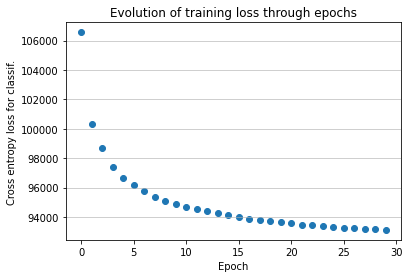

In [ ]:
with open('./drive/MyDrive/final_training_epoch_losses', 'rb') as f:
  training_losses = pickle.load(f)

plt.scatter(x = [k for k in range(len(training_losses))], y = training_losses)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Epoch')
plt.ylabel('Cross entropy loss for classif.')
plt.title('Evolution of training loss through epochs')

## SECTION 5 / EVALUATION OF THE MODEL ON MOVIES REVIEWS CLASSIFICATION TASK

In [ ]:
# testing by bootstrapping 1000 batches in test dataset (= 10 000 reviews in total) :
final_model.eval()

bootstrap_number = 50
bootstrap_size = 20
bootstrapped_accuracies = []

for boot in range(bootstrap_number):

  test_loader = DataLoader(dataset = cinema_reviews['test'], batch_size = 10,
                            num_workers=2, shuffle=True, drop_last=True)
  right_answers = 0
  true_test_size = 0 # few KeyError so we discount them

  for i in range(bootstrap_size):
    try:
      batch = next(iter(test_loader))
      true_label = batch['label'][0]
      probas = F.softmax(final_model(preprocessing(batch, max_dialog_size, max_size_of_utterance)[0]), dim = 1)
      votes = torch.sum(probas, axis=0)

      if votes[0] < votes[1]:
        pred = 1 
      else:
        pred = 0

      if pred == true_label:
        right_answers += 1
      
      true_test_size += 1
    
    except KeyError:
      pass

  bootstrapped_accuracies.append(right_answers/true_test_size)

(0.0, 20.0)

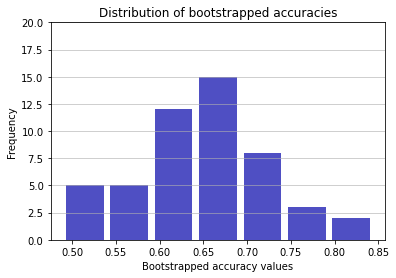

In [ ]:
n, bins, patches = plt.hist(x = bootstrapped_accuracies, bins = 'auto', color = '#0504aa',
                            alpha = 0.7, rwidth = 0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Bootstrapped accuracy values')
plt.ylabel('Frequency')
plt.title('Distribution of bootstrapped accuracies')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
# average accuracy over bootstrapped sets of reviews :
print('Average accuracy over bootstrapped sets of samples = ', int(np.mean(bootstrapped_accuracies)*100), '%')

Average accuracy over bootstrapped sets of samples =  64 %


## SECTION 6 / ASSESSMENT OF THE IMPACT OF PRETRAINING ON CLASSIFICATION 

In this section we want to know how the classification model would have behaved if no pretraining (hierarchical model with MLM loss) had been performed before training the classification layer weights:
* In the following cells we instanciate the pretraining model without any MLM loss training
* After that we train the classification layer weights for 30 epochs, as we did for our pretrained model, and then we evaluate the accuracy of this not pretrained classification model

In [ ]:
torch.manual_seed(0)
final_model = FinalModel(model_not_pretrained)
final_model.to(device)

FinalModel(
  (first_layer_encoders): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
    (linear1): Linear(in_features=100, out_features=100, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=100, out_features=100, bias=True)
    (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (second_layer_encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
    (linear1): Linear(in_features=100, out_features=100, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=100, out_features=100, bias=True)
    (norm1): Lay

In [ ]:
# optimization of parameters of classif layer 

def classif_trainer_2(final_model, num_epoch = 10, max_norm = 1, epoch_b4_stopping = 0, epoch_losses = [], classif_layer_only = True, clipping = True):

  if epoch_b4_stopping != 0:
    epoch_losses = epoch_losses
  else:
    epoch_losses = [0 for i in range(num_epoch)]

  if classif_layer_only == True:
    for param in final_model.parameters():
      param.requires_grad = False
    for param in final_model.classif_layer.parameters():
        param.requires_grad = True

  optimizer = opt.SGD(final_model.parameters(), lr=0.001, momentum=0.9)
  loss_fn = nn.CrossEntropyLoss()

  # training mode "train" only changes the "dropout" or "batchnorm" layers
  final_model.train()

  # main loop (train+test)
  for epoch in tqdm(range(epoch_b4_stopping, num_epoch)):

      if epoch == epoch_b4_stopping:
        epoch_losses[epoch] = 0 

      loss_100_batches = 0
      
      for batch_idx, batch in enumerate(train_loader):

          # Clear previous gradients in the graph
          optimizer.zero_grad()

          # compute batch loss
          loss = batch_loss_classif(batch)

          # Compute clipped gradients
          loss.backward()
          if clipping == True:
            utils.clip_grad_norm(final_model.parameters(), max_norm)

          epoch_losses[epoch] += loss.item()
          loss_100_batches += loss.item()

          # Apply Gradient descent
          optimizer.step()
          
          if batch_idx %100 ==0:
              print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*10,
                      len(train_loader.dataset),loss_100_batches))
              loss_100_batches = 0
              
          if batch_idx %1000 == 0:
            with open("./drive/MyDrive/final_training_params_saving_no_pretraining", "wb") as f:
              pickle.dump({'epoch_losses': epoch_losses, 'epoch_b4_stopping' : epoch}, f)
            torch.save(final_model, './drive/MyDrive/final_model_no_pretraining')

  with open("./drive/MyDrive/final_training_epoch_losses_no_pretraining", "wb") as f:
              pickle.dump(epoch_losses, f)
  torch.save(final_model, './drive/MyDrive/final_model_no_pretraining')

In [ ]:
classif_trainer_2(final_model, num_epoch = 30)

  0%|          | 0/30 [00:00<?, ?it/s]

epoch 0 batch 0 [0/160000] training loss: 9.418587684631348
epoch 0 batch 100 [1000/160000] training loss: 771.1224870681763
epoch 0 batch 200 [2000/160000] training loss: 726.0660371780396
epoch 0 batch 300 [3000/160000] training loss: 709.7422337532043
epoch 0 batch 400 [4000/160000] training loss: 716.8814163208008
epoch 0 batch 500 [5000/160000] training loss: 713.0321044921875
epoch 0 batch 600 [6000/160000] training loss: 681.4173812866211
epoch 0 batch 700 [7000/160000] training loss: 694.5596301555634
epoch 0 batch 800 [8000/160000] training loss: 679.0434510707855
epoch 0 batch 900 [9000/160000] training loss: 702.944591999054
epoch 0 batch 1000 [10000/160000] training loss: 671.0274631977081
epoch 0 batch 1100 [11000/160000] training loss: 688.3555669784546
epoch 0 batch 1200 [12000/160000] training loss: 668.4535999298096
epoch 0 batch 1300 [13000/160000] training loss: 702.5404033660889
epoch 0 batch 1400 [14000/160000] training loss: 703.2277233600616
epoch 0 batch 1500 [1

KeyboardInterrupt: ignored

In [ ]:
# /!\ run this cell if training was interrupted by colab /
with open('./drive/MyDrive/final_training_params_saving_no_pretraining', 'rb') as f:
  final_training_params_saving = pickle.load(f)

final_model = torch.load('./drive/MyDrive/final_model_no_pretraining')
classif_trainer_2(final_model, num_epoch = 30, epoch_b4_stopping = final_training_params_saving['epoch_b4_stopping'],
                epoch_losses = final_training_params_saving['epoch_losses'], classif_layer_only = True)

  0%|          | 0/14 [00:00<?, ?it/s]

epoch 16 batch 0 [0/160000] training loss: 3.081878185272217
epoch 16 batch 100 [1000/160000] training loss: 573.7484266757965
epoch 16 batch 200 [2000/160000] training loss: 579.3174465894699
epoch 16 batch 300 [3000/160000] training loss: 566.7664355039597
epoch 16 batch 400 [4000/160000] training loss: 543.5041004419327
epoch 16 batch 500 [5000/160000] training loss: 576.3152234554291
epoch 16 batch 600 [6000/160000] training loss: 568.8788695335388
epoch 16 batch 700 [7000/160000] training loss: 568.49640583992
epoch 16 batch 800 [8000/160000] training loss: 527.4498383998871
epoch 16 batch 900 [9000/160000] training loss: 522.7220499515533
epoch 16 batch 1000 [10000/160000] training loss: 576.153591632843
epoch 16 batch 1100 [11000/160000] training loss: 557.0251854658127
epoch 16 batch 1200 [12000/160000] training loss: 555.9404444694519
epoch 16 batch 1300 [13000/160000] training loss: 557.6600561141968
epoch 16 batch 1400 [14000/160000] training loss: 564.1210851669312
epoch 16

Plotting the evolution of the training loss throughout the epochs :

Text(0.5, 1.0, 'Evolution of training loss through epochs ; no pretraining')

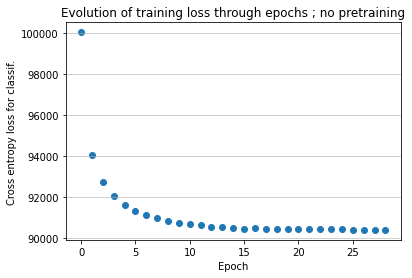

In [ ]:
with open('./drive/MyDrive/final_training_epoch_losses_no_pretraining', 'rb') as f:
  training_losses = pickle.load(f)

plt.scatter(x = [k for k in range(len(training_losses))], y = training_losses)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Epoch')
plt.ylabel('Cross entropy loss for classif.')
plt.title('Evolution of training loss through epochs ; no pretraining')

Evaluating the accuracy of the classification model after 30 training epochs but WITHOUT PRETRAINING :

In [ ]:
# testing by bootstrapping 1000 batches in test dataset (= 10 000 reviews in total) :
final_model = torch.load('./drive/MyDrive/final_model_no_pretraining')
final_model.eval()

bootstrap_number = 50
bootstrap_size = 20
bootstrapped_accuracies = []

for boot in range(bootstrap_number):

  test_loader = DataLoader(dataset = cinema_reviews['test'], batch_size = 10,
                            num_workers=2, shuffle=True, drop_last=True)
  right_answers = 0
  true_test_size = 0 # few KeyError so we discount them

  for i in range(bootstrap_size):
    try:
      batch = next(iter(test_loader))
      true_label = batch['label'][0]
      probas = F.softmax(final_model(preprocessing(batch, max_dialog_size, max_size_of_utterance)[0]), dim = 1)
      votes = torch.sum(probas, axis=0)

      if votes[0] < votes[1]:
        pred = 1 
      else:
        pred = 0

      if pred == true_label:
        right_answers += 1
      
      true_test_size += 1
    
    except KeyError:
      pass

  bootstrapped_accuracies.append(right_answers/true_test_size)


# average accuracy over bootstrapped sets of reviews :
print('Average accuracy over bootstrapped sets of samples WITHOUT PRETRAINING = ', int(np.mean(bootstrapped_accuracies)*100), '%')

Average accuracy over bootstrapped sets of samples WITHOUT PRETRAINING =  68 %
